In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from pandas.plotting import autocorrelation_plot

/tmp/ipython-input-751365063.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('household_power_consumption.txt', sep=';')


O percentual de registros faltantes é  1.25%


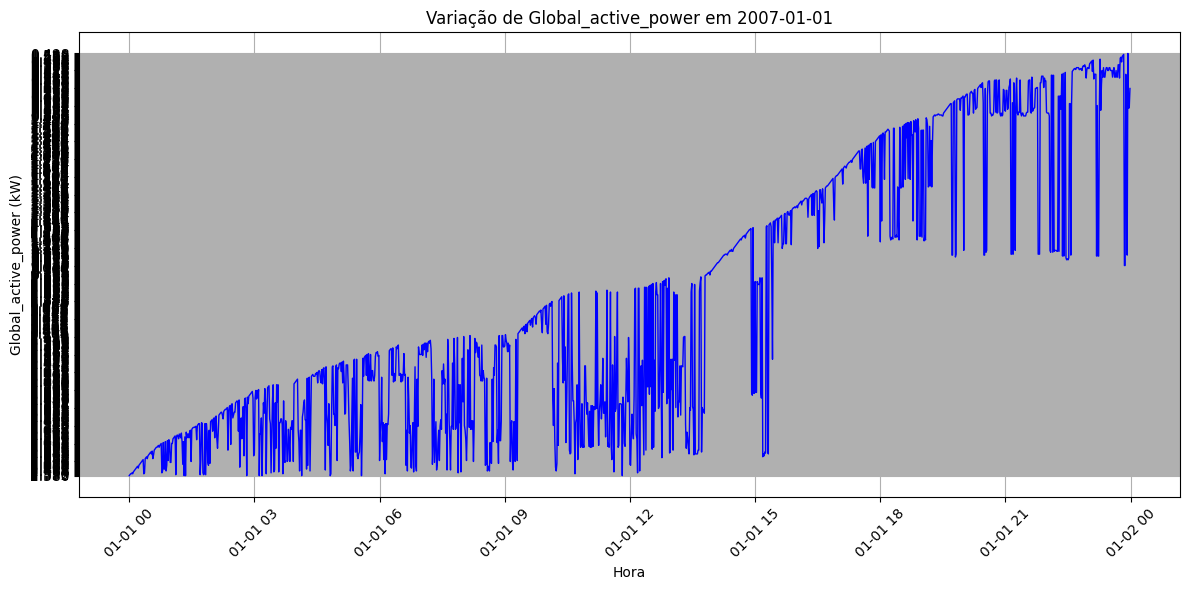

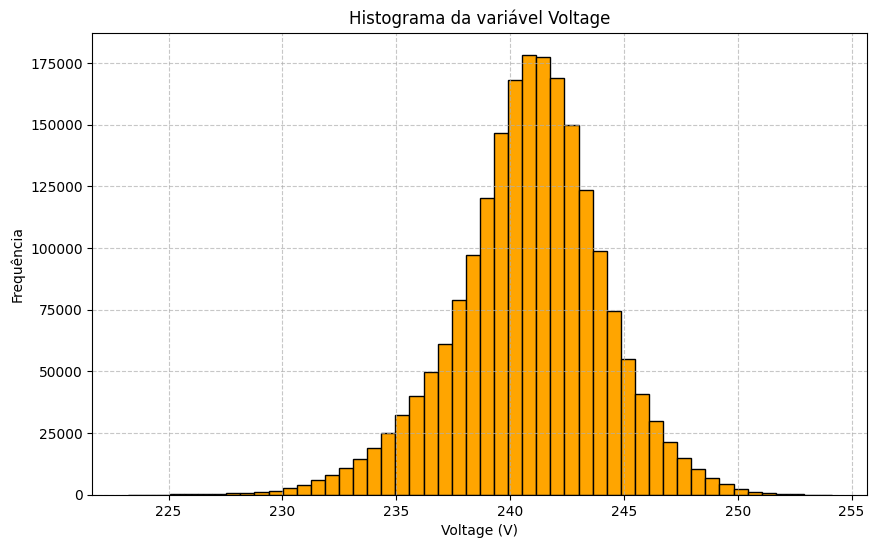

Ano   Mes
2006  12     1.901295
2007  1      1.546034
      2      1.401084
      3      1.318627
      4      0.891189
      5      0.985862
      6      0.826814
      7      0.667367
      8      0.764186
      9      0.969318
      10     1.103911
      11     1.294473
Name: Media_Global_active_power, dtype: float64


In [22]:

df = pd.read_csv('household_power_consumption.txt', sep=';')
#1-
df.head(10)

#2- #Global_active_power. É a potência realmente consumida pelos equipamentos para realizar trabalho útil.
   #Global_reactive_power. É a potência que não realiza trabalho útil, mas é necessária para sustentar os campos elétricos e magnéticos de equipamentos como motores, transformadores e lâmpadas fluorescentes.

#3 -
df.isna().sum()
perc = 100 * (25979 / df.shape[0])
print(f'O percentual de registros faltantes é {perc: .2f}%')


#4-
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
df["Dia_da_Semana"] = df["Date"].dt.day_name()

#5 -
df_2007 = df[df["Date"].dt.year == 2007].copy()
df_2007['DateTime'] = pd.to_datetime(df_2007['Date'].astype(str) + ' ' + df_2007['Time'])

#6 -
dia_escolhido = '2007-01-01'

df_dia = df_2007[df_2007['Date'] == pd.to_datetime(dia_escolhido)]

gcol = 'Global_active_power'

plt.figure(figsize=(12,6))
plt.plot(df_dia['DateTime'], df_dia[gcol], color='blue', linewidth=1)
plt.title(f'Variação de {gcol} em {dia_escolhido}')
plt.xlabel('Hora')
plt.ylabel(f'{gcol} (kW)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#7 -
vcol = None
for c in df.columns:
    if 'voltage' in c.lower().replace(" ", "_"):
        vcol = c
        break

if vcol is None:
    raise KeyError("Coluna 'Voltage' não encontrada. Verifique o nome exato no dataset.")

df[vcol] = pd.to_numeric(df[vcol].astype(str).str.replace('?', '', regex=False).str.replace(',', '.', regex=False), errors='coerce')

plt.figure(figsize=(10,6))
plt.hist(df[vcol].dropna(), bins=50, color='orange', edgecolor='black')
plt.title('Histograma da variável Voltage')
plt.xlabel('Voltage (V)')
plt.ylabel('Frequência')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#8 -
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'])

df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

df.dropna(subset=['Global_active_power'], inplace=True)


df['Ano'] = df['DateTime'].dt.year
df['Mes'] = df['DateTime'].dt.month

consumo_mensal = df.groupby(['Ano', 'Mes'])['Global_active_power'].mean().rename('Media_Global_active_power')

print(consumo_mensal.head(12))

In [25]:
#9-
consumo = df.groupby(df['DateTime'].dt.date)['Global_active_power'].sum()
consumoMaximoDiario = consumo.idxmax()
print(f"O dia com o maior consumo de energia ativa global foi {consumoMaximoDiario}\n")

#10 -

df['Tipo_Dia'] = df['Dia_da_Semana'].apply(lambda x: 'Fim de Semana' if x in ['Saturday', 'Sunday'] else 'Dia de Semana')

consumo_medio_por_tipo_dia = df.groupby('Tipo_Dia')['Global_active_power'].mean()
print("Consumo médio de energia ativa global por tipo de dia:")
print(f"{consumo_medio_por_tipo_dia}\n")

#11 -


colunas = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']
df_selecionado = df[colunas]

for col in colunas:
    df_selecionado[col] = pd.to_numeric(df_selecionado[col], errors='coerce')

correlaçao = df_selecionado.corr()

print("Matriz de Correlação:")
display(correlaçao)


#12 -
df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'], errors='coerce')
df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'], errors='coerce')
df['Sub_metering_3'] = pd.to_numeric(df['Sub_metering_3'], errors='coerce')

df['Total_Sub_metering'] = df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']
display(df.head())

O dia com o maior consumo de energia ativa global foi 2006-12-23

Consumo médio de energia ativa global por tipo de dia:
Tipo_Dia
Dia de Semana    1.035472
Fim de Semana    1.234232
Name: Global_active_power, dtype: float64



/tmp/ipython-input-3472453916.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selecionado[col] = pd.to_numeric(df_selecionado[col], errors='coerce')


Matriz de Correlação:


,Global_active_power,Global_reactive_power,Voltage,Global_intensity
Global_active_power,1.000000,0.247017,-0.399762,0.998889
Global_reactive_power,0.247017,1.000000,-0.112246,0.266120
Voltage,-0.399762,-0.112246,1.000000,-0.411363
Global_intensity,0.998889,0.266120,-0.411363,1.000000


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Dia_da_Semana,DateTime,Ano,Mes,Tipo_Dia,Total_Sub_metering
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.400,0.0,1.0,17.0,Saturday,2006-12-16 17:24:00,2006,12,Fim de Semana,18.0
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.000,0.0,1.0,16.0,Saturday,2006-12-16 17:25:00,2006,12,Fim de Semana,17.0
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.000,0.0,2.0,17.0,Saturday,2006-12-16 17:26:00,2006,12,Fim de Semana,19.0
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.000,0.0,1.0,17.0,Saturday,2006-12-16 17:27:00,2006,12,Fim de Semana,18.0
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.800,0.0,1.0,17.0,Saturday,2006-12-16 17:28:00,2006,12,Fim de Semana,18.0


In [26]:
#13 -

df['Ano'] = df['DateTime'].dt.year
df['Mes'] = df['DateTime'].dt.month

consumo_mensal_total_sub_metering = df.groupby(['Ano', 'Mes'])['Total_Sub_metering'].mean()
consumo_mensal_global_active_power = df.groupby(['Ano', 'Mes'])['Global_active_power'].mean()

meses_ultrapassados = consumo_mensal_total_sub_metering[consumo_mensal_total_sub_metering > consumo_mensal_global_active_power]

if not meses_ultrapassados.empty:
    print("Meses em que a média de Total_Sub_metering ultrapassa a média de Global_active_power:")
    print(meses_ultrapassados)
else:
    print("Não há meses em que a média de Total_Sub_metering ultrapassa a média de Global_active_power.")

Meses em que a média de Total_Sub_metering ultrapassa a média de Global_active_power:
Ano   Mes
2006  12     10.873181
2007  1      10.423518
      2       9.486135
      3      10.212863
      4       6.839375
      5       8.452442
      6       7.379151
      7       5.697724
      8       6.979336
      9       8.206236
      10      8.674493
      11      9.819413
      12     11.636551
2008  1       9.786218
      2       8.447829
      3       9.454894
      4       9.574745
      5       9.019468
      6       9.775226
      7       7.145414
      8       2.370223
      9       8.825185
      10      8.592686
      11      9.135445
      12      8.793377
2009  1      10.690405
      2       9.786069
      3       9.896702
      4       9.605699
      5       9.067053
      6       8.049430
      7       5.571512
      8       6.041372
      9       9.127787
      10      9.766393
      11     10.404107
      12     11.093687
2010  1      12.198993
      2      12.762835
      3

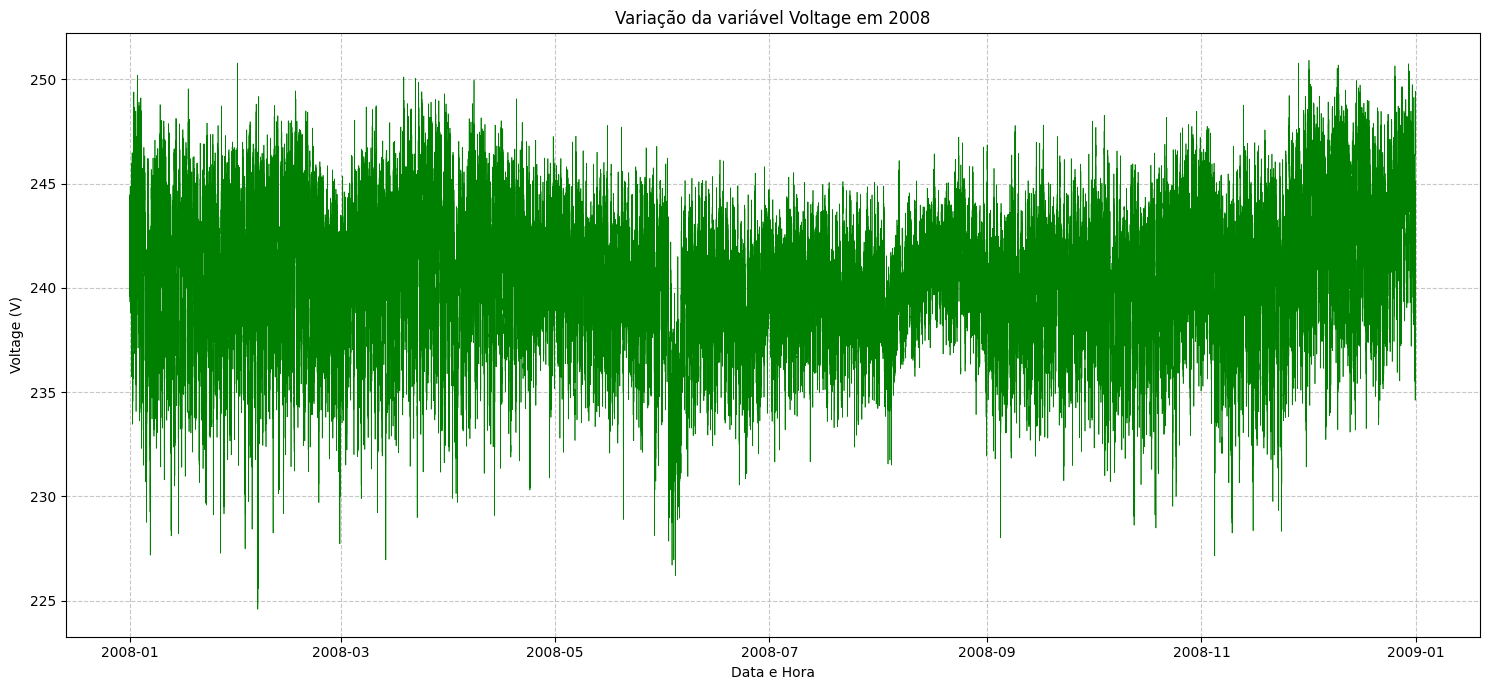

In [27]:
# 14 -
df_2008 = df[df['DateTime'].dt.year == 2008].copy()
plt.figure(figsize=(15, 7))
plt.plot(df_2008['DateTime'], df_2008['Voltage'], color='green', linewidth=0.5)
plt.title('Variação da variável Voltage em 2008')
plt.xlabel('Data e Hora')
plt.ylabel('Voltage (V)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [28]:
#15 -
# Verão: Junho, Julho, Agosto
# Inverno: Dezembro, Janeiro, Fevereiro

def estacao(mes):
    if mes in [6, 7, 8]:
        return 'Verão'
    elif mes in [12, 1, 2]:
        return 'Inverno'
    else:
        return None # Ou outra categoria para as estações intermediárias

df['Estacao'] = df['DateTime'].dt.month.apply(estacao)
display(df.head())

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Dia_da_Semana,DateTime,Ano,Mes,Tipo_Dia,Total_Sub_metering,Estacao
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.400,0.0,1.0,17.0,Saturday,2006-12-16 17:24:00,2006,12,Fim de Semana,18.0,Inverno
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.000,0.0,1.0,16.0,Saturday,2006-12-16 17:25:00,2006,12,Fim de Semana,17.0,Inverno
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.000,0.0,2.0,17.0,Saturday,2006-12-16 17:26:00,2006,12,Fim de Semana,19.0,Inverno
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.000,0.0,1.0,17.0,Saturday,2006-12-16 17:27:00,2006,12,Fim de Semana,18.0,Inverno
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.800,0.0,1.0,17.0,Saturday,2006-12-16 17:28:00,2006,12,Fim de Semana,18.0,Inverno


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Dia_da_Semana,DateTime,Ano,Mes,Tipo_Dia,Total_Sub_metering,Estacao
1030580,2008-12-01,09:44:00,1.502,0.074,240.17,6.400,0.0,0.0,18.0,Monday,2008-12-01 09:44:00,2008,12,Dia de Semana,18.0,Inverno
1815,2006-12-17,23:39:00,0.374,0.264,245.50,1.800,0.0,2.0,0.0,Sunday,2006-12-17 23:39:00,2006,12,Fim de Semana,2.0,Inverno
1295977,2009-06-03,17:01:00,0.620,0.300,239.85,3.000,0.0,1.0,1.0,Wednesday,2009-06-03 17:01:00,2009,6,Dia de Semana,2.0,Verão
206669,2007-05-09,05:53:00,0.280,0.200,235.72,1.400,0.0,0.0,0.0,Wednesday,2007-05-09 05:53:00,2007,5,Dia de Semana,0.0,None
1048893,2008-12-14,02:57:00,1.372,0.054,243.95,5.600,0.0,0.0,18.0,Sunday,2008-12-14 02:57:00,2008,12,Fim de Semana,18.0,Inverno


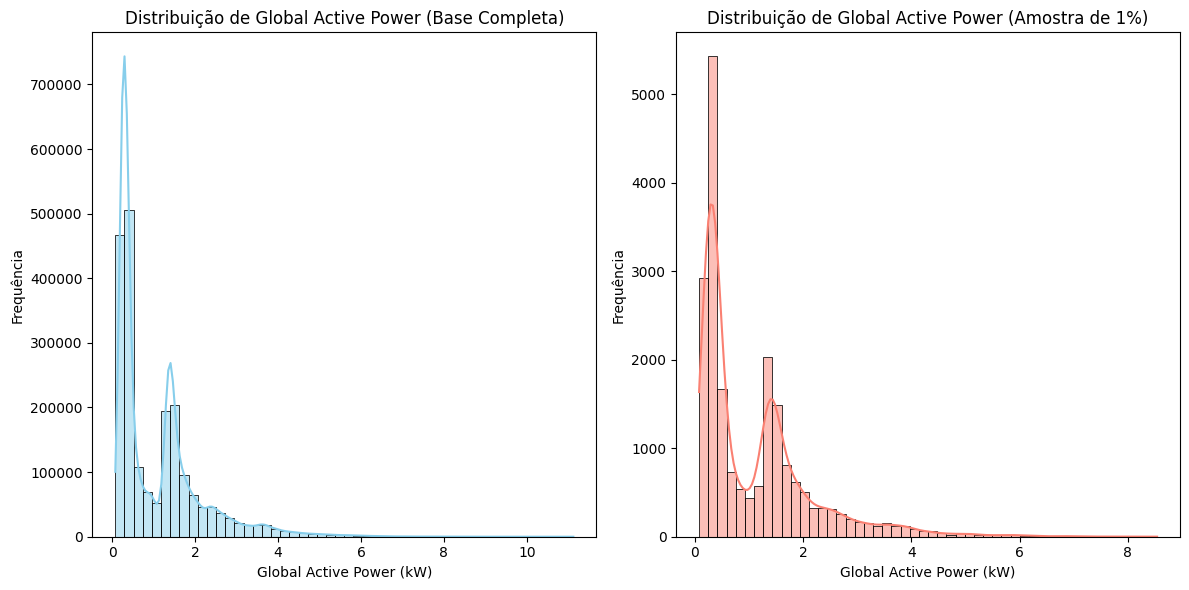

In [29]:
#16 -

df_sample = df.sample(frac=0.01, random_state=42) # random_state para reprodutibilidade
display(df_sample.head())
plt.figure(figsize=(12, 6))

# Histograma da base completa
plt.subplot(1, 2, 1)
sns.histplot(df['Global_active_power'].dropna(), bins=50, color='skyblue', edgecolor='black', kde=True)
plt.title('Distribuição de Global Active Power (Base Completa)')
plt.xlabel('Global Active Power (kW)')
plt.ylabel('Frequência')

# Histograma da amostra
plt.subplot(1, 2, 2)
sns.histplot(df_sample['Global_active_power'].dropna(), bins=50, color='salmon', edgecolor='black', kde=True)
plt.title('Distribuição de Global Active Power (Amostra de 1%)')
plt.xlabel('Global Active Power (kW)')
plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

In [30]:
#17

cols_norm = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']
df_norm = df[cols_norm].dropna().copy()

scaler = MinMaxScaler()
df_norm_scaled = pd.DataFrame(scaler.fit_transform(df_norm), columns=cols_norm)

print(df_norm_scaled.head())


   Global_active_power  Global_reactive_power   Voltage  Global_intensity
0             0.374796               0.300719  0.376090          0.377593
1             0.478363               0.313669  0.336995          0.473029
2             0.479631               0.358273  0.326010          0.473029
3             0.480898               0.361151  0.340549          0.473029
4             0.325005               0.379856  0.403231          0.323651


         Global_active_power
Cluster                     
0                   0.689159
1                   1.208707
2                   1.869834


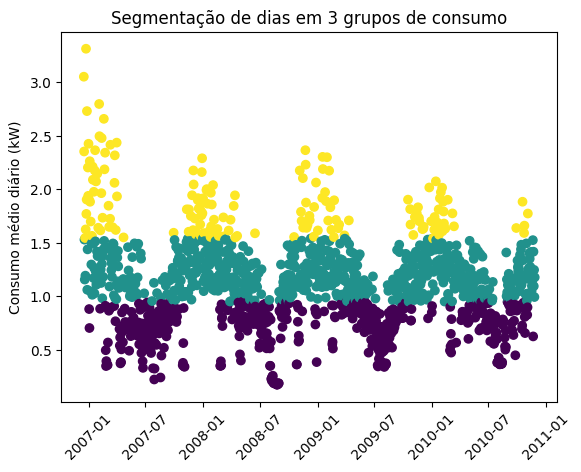

In [31]:
#18

df_daily = df.groupby(df['DateTime'].dt.date)['Global_active_power'].mean().to_frame()

kmeans = KMeans(n_clusters=3, random_state=42)
df_daily['Cluster'] = kmeans.fit_predict(df_daily)

print(df_daily.groupby('Cluster').mean())

plt.scatter(df_daily.index, df_daily['Global_active_power'], c=df_daily['Cluster'], cmap='viridis')
plt.xticks(rotation=45)
plt.title("Segmentação de dias em 3 grupos de consumo")
plt.ylabel("Consumo médio diário (kW)")
plt.show()


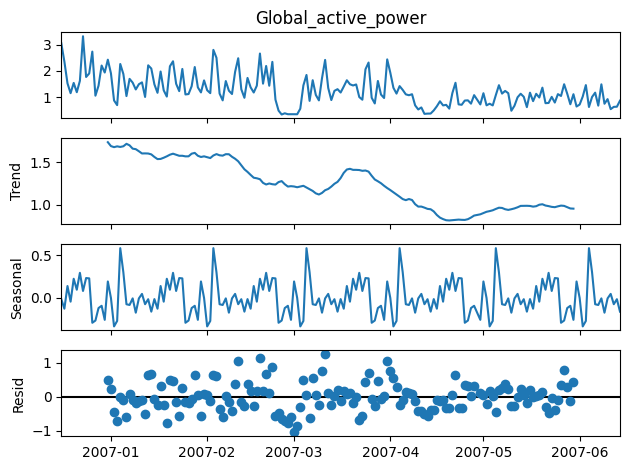

In [32]:
#19

df_6m = df.set_index('DateTime')['Global_active_power'].resample('D').mean().dropna().iloc[:180]

decomp = seasonal_decompose(df_6m, model='additive', period=30)
decomp.plot()
plt.show()


In [33]:
#20

X = df[['Global_intensity']].dropna()
y = df['Global_active_power'].dropna().loc[X.index]

modelo = LinearRegression()
modelo.fit(X, y)

y_pred = modelo.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print("Coeficiente angular:", modelo.coef_[0])
print("Intercepto:", modelo.intercept_)
print("RMSE:", rmse)


Coeficiente angular: 0.23762937030186282
Intercepto: -0.008076494382778465
RMSE: 0.0498339346935975


/tmp/ipython-input-3563081530.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.set_index('DateTime')['Global_active_power'].resample('H').mean()


DateTime
20    1.899073
21    1.876063
19    1.733428
7     1.502373
8     1.460940
Name: Global_active_power, dtype: float64


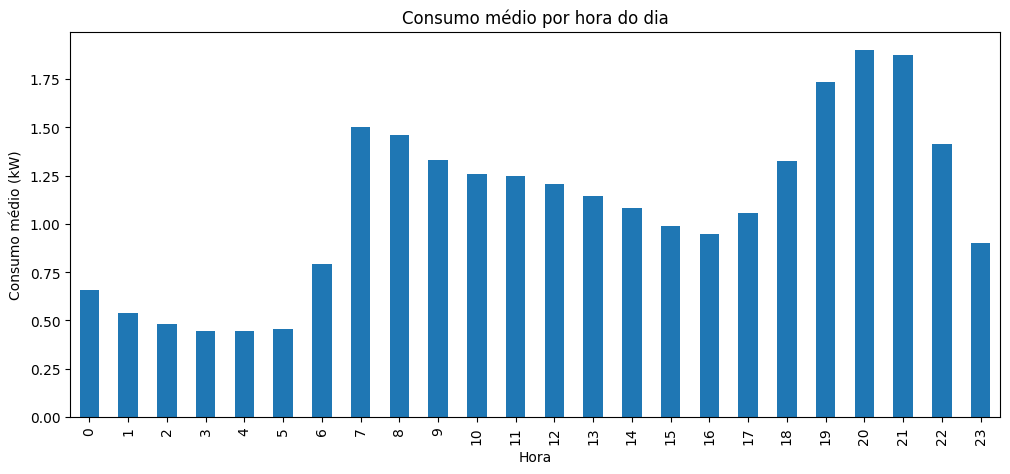

In [34]:
#21
df_hourly = df.set_index('DateTime')['Global_active_power'].resample('H').mean()

consumo_por_hora = df_hourly.groupby(df_hourly.index.hour).mean()
print(consumo_por_hora.sort_values(ascending=False).head())

consumo_por_hora.plot(kind='bar', figsize=(12,5))
plt.title("Consumo médio por hora do dia")
plt.xlabel("Hora")
plt.ylabel("Consumo médio (kW)")
plt.show()


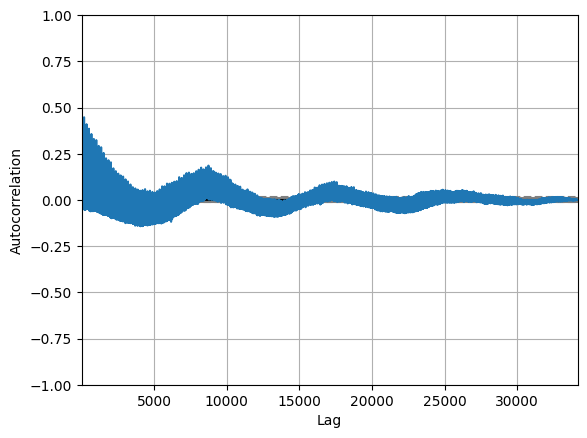

Lag 1h: 0.713343387922962
Lag 24h: 0.4351862386607033
Lag 48h: 0.3990179423908085


In [35]:
#22

serie = df_hourly.dropna()
autocorrelation_plot(serie)
plt.show()

print("Lag 1h:", serie.autocorr(lag=1))
print("Lag 24h:", serie.autocorr(lag=24))
print("Lag 48h:", serie.autocorr(lag=48))


In [36]:
#23

X = df[cols_norm].dropna()
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

print("Variância explicada por cada componente:", pca.explained_variance_ratio_)


Variância explicada por cada componente: [0.75442158 0.24513217]


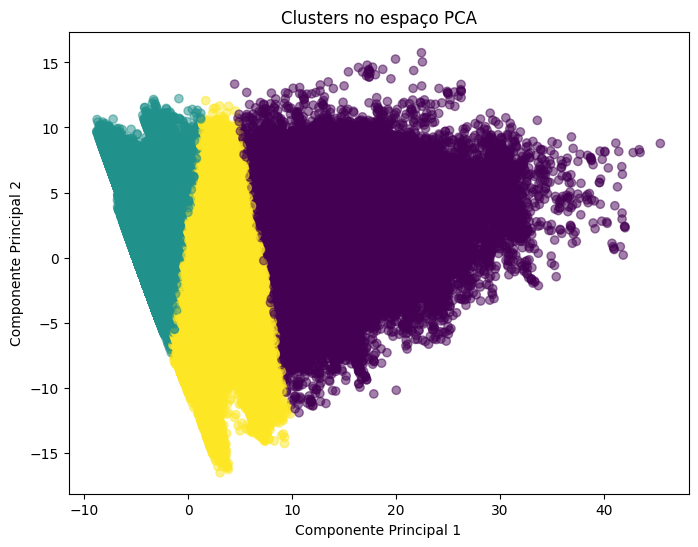

In [37]:
#24
# PCA
X_pca = pca.fit_transform(X)

kmeans_pca = KMeans(n_clusters=3, random_state=42)
clusters_pca = kmeans_pca.fit_predict(X_pca)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters_pca, cmap='viridis', alpha=0.5)
plt.title("Clusters no espaço PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.show()


Comparação de Modelos:
RMSE Linear Simples: 0.9719
RMSE Polinomial (grau 2): 0.9674


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


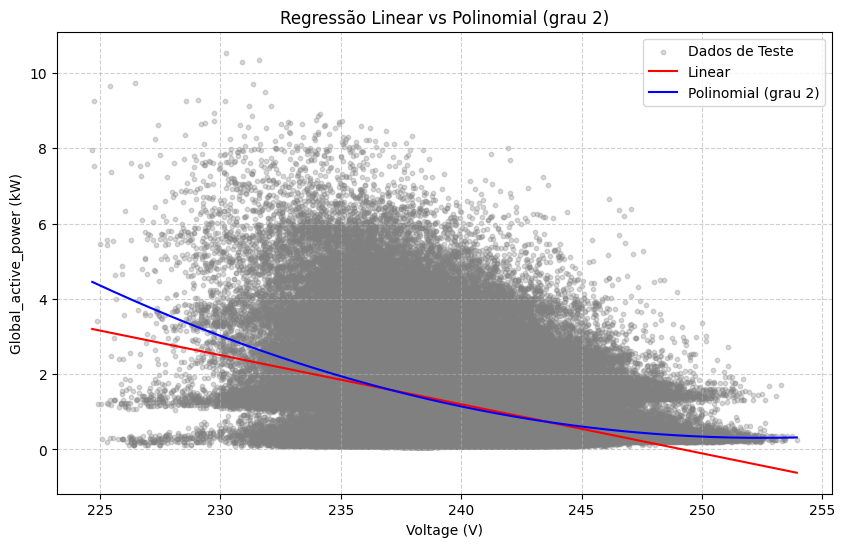

In [38]:
#25 - Regressão Linear vs Polinomial (grau 2)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# Preparar os dados
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')
df_reg = df.dropna(subset=['Global_active_power', 'Voltage']).copy()

X = df_reg[['Voltage']]
y = df_reg['Global_active_power']

# Dividir treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Regressão Linear Simples
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))

# Regressão Polinomial (grau 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
y_pred_poly = poly_model.predict(X_test_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))

# Resultados
print("Comparação de Modelos:")
print(f"RMSE Linear Simples: {rmse_linear:.4f}")
print(f"RMSE Polinomial (grau 2): {rmse_poly:.4f}")

# Visualização
plt.figure(figsize=(10,6))

# Ordenar X_test para curva suave
X_sorted = np.sort(X_test.values.flatten())
X_sorted_poly = poly.transform(X_sorted.reshape(-1,1))

plt.scatter(X_test, y_test, alpha=0.3, label="Dados de Teste", color="gray", s=10)
plt.plot(X_sorted, linear_model.predict(X_sorted.reshape(-1,1)), color="red", label="Linear")
plt.plot(X_sorted, poly_model.predict(X_sorted_poly), color="blue", label="Polinomial (grau 2)")

plt.title("Regressão Linear vs Polinomial (grau 2)")
plt.xlabel("Voltage (V)")
plt.ylabel("Global_active_power (kW)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [5]:
#26 - Carregamento e Inspeção Inicial

# Carregar o dataset
df = pd.read_csv('energydata_complete.csv')

# Exibir informações gerais sobre o dataset
print("=== Informações do DataFrame ===")
print(df.info())

# Estatísticas descritivas
print("\n=== Estatísticas Descritivas ===")
print(df.describe(include='all'))

=== Informações do DataFrame ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         

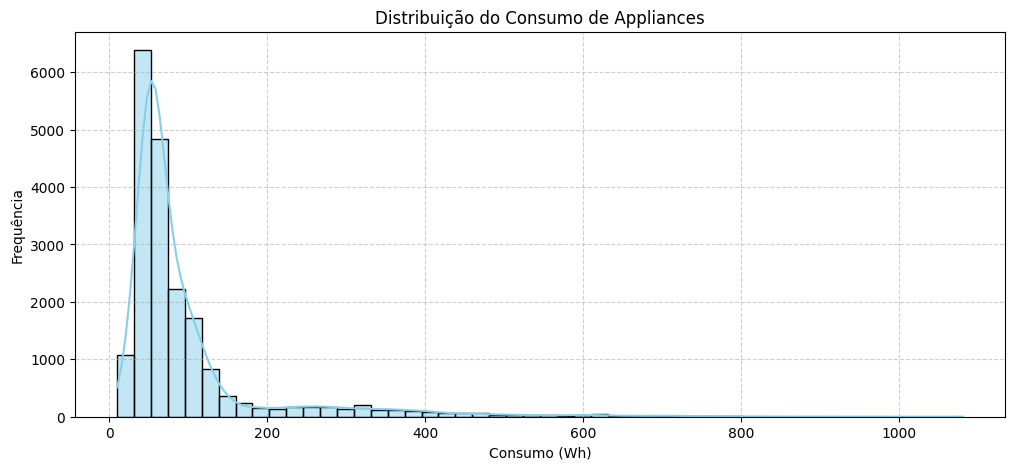

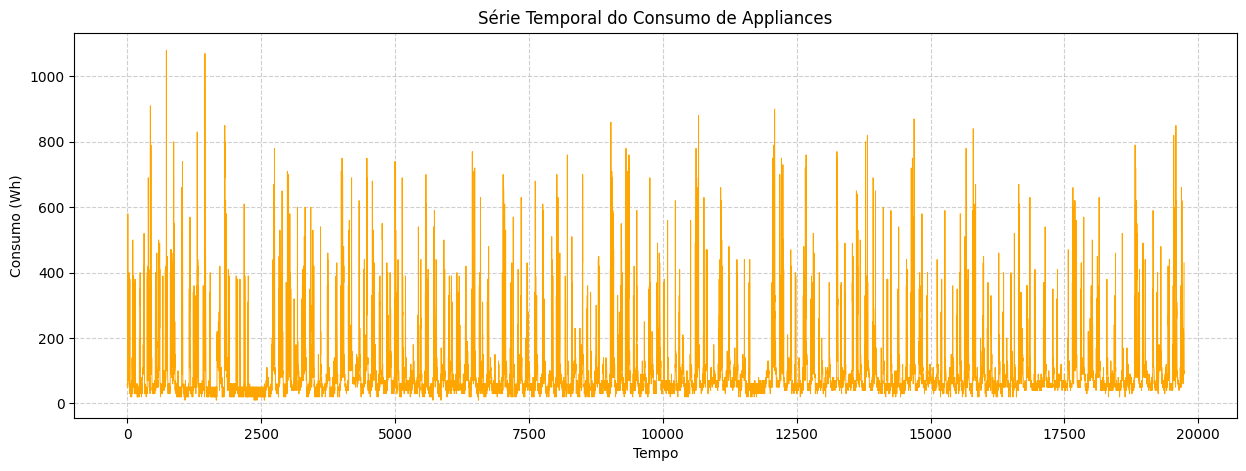

Observação: O consumo de Appliances tende a se concentrar em valores mais baixos,
com picos ocasionais que indicam uso intenso em certos momentos.


In [6]:
#27 - Distribuição do Consumo (Appliances)

# Garantir que a coluna seja numérica
df['Appliances'] = pd.to_numeric(df['Appliances'], errors='coerce')

# Histograma da variável Appliances
plt.figure(figsize=(12,5))
sns.histplot(df['Appliances'].dropna(), bins=50, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribuição do Consumo de Appliances')
plt.xlabel('Consumo (Wh)')
plt.ylabel('Frequência')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Série temporal do consumo
plt.figure(figsize=(15,5))
plt.plot(df.index, df['Appliances'], linewidth=0.7, color='orange')
plt.title('Série Temporal do Consumo de Appliances')
plt.xlabel('Tempo')
plt.ylabel('Consumo (Wh)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Análise
print("Observação: O consumo de Appliances tende a se concentrar em valores mais baixos,")
print("com picos ocasionais que indicam uso intenso em certos momentos.")


=== Correlações de Appliances com variáveis ambientais ===
Appliances    1.000000
T2            0.120073
T_out         0.099155
RH_1          0.086031
T3            0.085060
T1            0.055447
RH_3          0.036292
RH_2         -0.060465
RH_out       -0.152282
Name: Appliances, dtype: float64


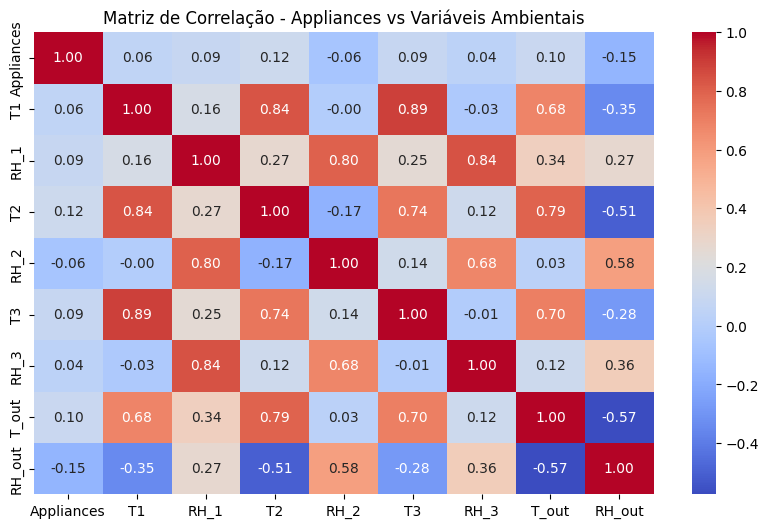


Observação: Valores de temperatura e umidade interna tendem a ter correlação mais forte com o consumo,
enquanto variáveis externas geralmente apresentam correlação mais fraca.


In [8]:
#28 - Correlações com variáveis ambientais

# Garantir que os dados estejam no formato numérico
variaveis_ambientais = ['T1','RH_1','T2','RH_2','T3','RH_3','T_out','RH_out']
for col in ['Appliances'] + variaveis_ambientais:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Selecionar colunas de interesse
df_corr = df[['Appliances'] + variaveis_ambientais].dropna()

# Matriz de correlação
corr = df_corr.corr()

# Mostrar apenas correlações com Appliances
print("=== Correlações de Appliances com variáveis ambientais ===")
print(corr['Appliances'].sort_values(ascending=False))

# Visualizar matriz de correlação
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Matriz de Correlação - Appliances vs Variáveis Ambientais")
plt.show()

# Análise
print("\nObservação: Valores de temperatura e umidade interna tendem a ter correlação mais forte com o consumo,")
print("enquanto variáveis externas geralmente apresentam correlação mais fraca.")


In [13]:
# 29. Normalização dos dados

from sklearn.preprocessing import MinMaxScaler

# Seleciona apenas as colunas numéricas (excluindo a coluna alvo se quiser)
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Inicializa o scaler
scaler = MinMaxScaler()

# Aplica Min-Max Scaling
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Agora 'df' está normalizado e pronto para ser usado nos modelos posteriores
print(df.head())


                  date  Appliances    lights       T1      RH_1        T2  \
0  2016-01-11 17:00:00    0.046729  0.428571  0.32735  0.566187  0.225345   
1  2016-01-11 17:10:00    0.046729  0.428571  0.32735  0.541326  0.225345   
2  2016-01-11 17:20:00    0.037383  0.428571  0.32735  0.530502  0.225345   
3  2016-01-11 17:30:00    0.037383  0.571429  0.32735  0.524080  0.225345   
4  2016-01-11 17:40:00    0.046729  0.571429  0.32735  0.531419  0.225345   

       RH_2        T3      RH_3        T4  ...        T9      RH_9     T_out  \
0  0.684038  0.215188  0.746066  0.351351  ...  0.223032  0.677290  0.372990   
1  0.682140  0.215188  0.748871  0.351351  ...  0.226500  0.678532  0.369239   
2  0.679445  0.215188  0.755569  0.344745  ...  0.219563  0.676049  0.365488   
3  0.678414  0.215188  0.758685  0.341441  ...  0.219563  0.671909  0.361736   
4  0.676727  0.215188  0.758685  0.341441  ...  0.219563  0.671909  0.357985   

   Press_mm_hg    RH_out  Windspeed  Visibility  Tdewpoi

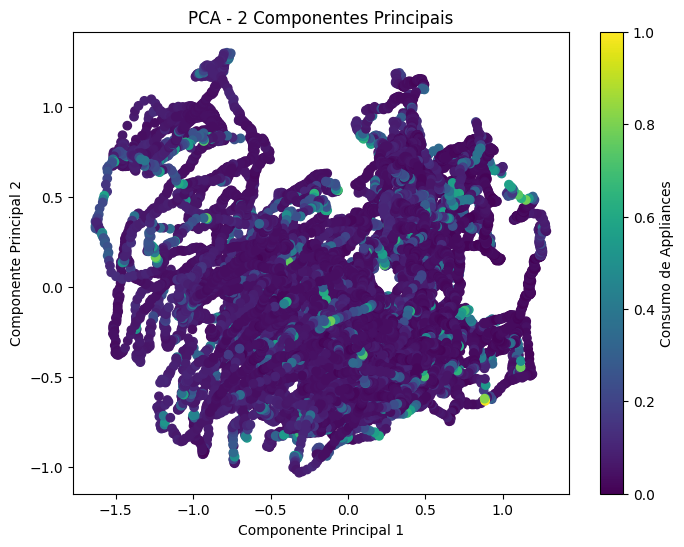

In [15]:
# 30. PCA

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Seleciona apenas as variáveis numéricas (excluindo a coluna alvo e a coluna 'date')
X = df.drop(['Appliances', 'date'], axis=1)

# Aplica PCA para reduzir para 2 componentes principais
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Cria DataFrame dos componentes principais
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Appliances'] = df['Appliances']  # para referência

# Plota os dados resultantes
plt.figure(figsize=(8,6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['Appliances'], cmap='viridis')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA - 2 Componentes Principais')
plt.colorbar(label='Consumo de Appliances')
plt.show()

In [17]:
# 31. Regressão Linear Múltipla

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X = df.drop(['Appliances', 'date'], axis=1)
y = df['Appliances']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("R²:", r2)
print("MSE:", mse)
print("RMSE:", rmse)

R²: 0.16930416505473977
MSE: 0.007260764164342289
RMSE: 0.08521011773458766


In [18]:
# 32. Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# X e y já estão definidos (do exercício anterior)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializa o modelo
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Previsões
y_pred_rf = rf_model.predict(X_test)

# Avaliação
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print("Random Forest R²:", r2_rf)
print("Random Forest MSE:", mse_rf)
print("Random Forest RMSE:", rmse_rf)

# Comparação rápida com Regressão Linear
print("\nComparação com Regressão Linear:")
print("RMSE Linear:", np.sqrt(mean_squared_error(y_test, model.predict(X_test))))
print("RMSE Random Forest:", rmse_rf)


Random Forest R²: 0.5313941567585656
Random Forest MSE: 0.004095887291926791
Random Forest RMSE: 0.06399911946212065

Comparação com Regressão Linear:
RMSE Linear: 0.08521011773458766
RMSE Random Forest: 0.06399911946212065


Exercicio 34

Mediana do consumo: 100.76
Distribuição das classes:
consumo_alto
1    500
0    500
Name: count, dtype: int64
Proporção: 50.00% de consumo alto

Dimensões dos conjuntos:
Treino: (700, 6), Teste: (300, 6)

REGRESSÃO LOGÍSTICA
Acurácia: 0.5200

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.52      0.53      0.52       150
           1       0.52      0.51      0.52       150

    accuracy                           0.52       300
   macro avg       0.52      0.52      0.52       300
weighted avg       0.52      0.52      0.52       300


RANDOM FOREST CLASSIFIER
Acurácia: 0.5033

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.50      0.48      0.49       150
           1       0.50      0.53      0.51       150

    accuracy                           0.50       300
   macro avg       0.50      0.50      0.50       300
weighted avg       0.50      0.50      0.50       300


Im

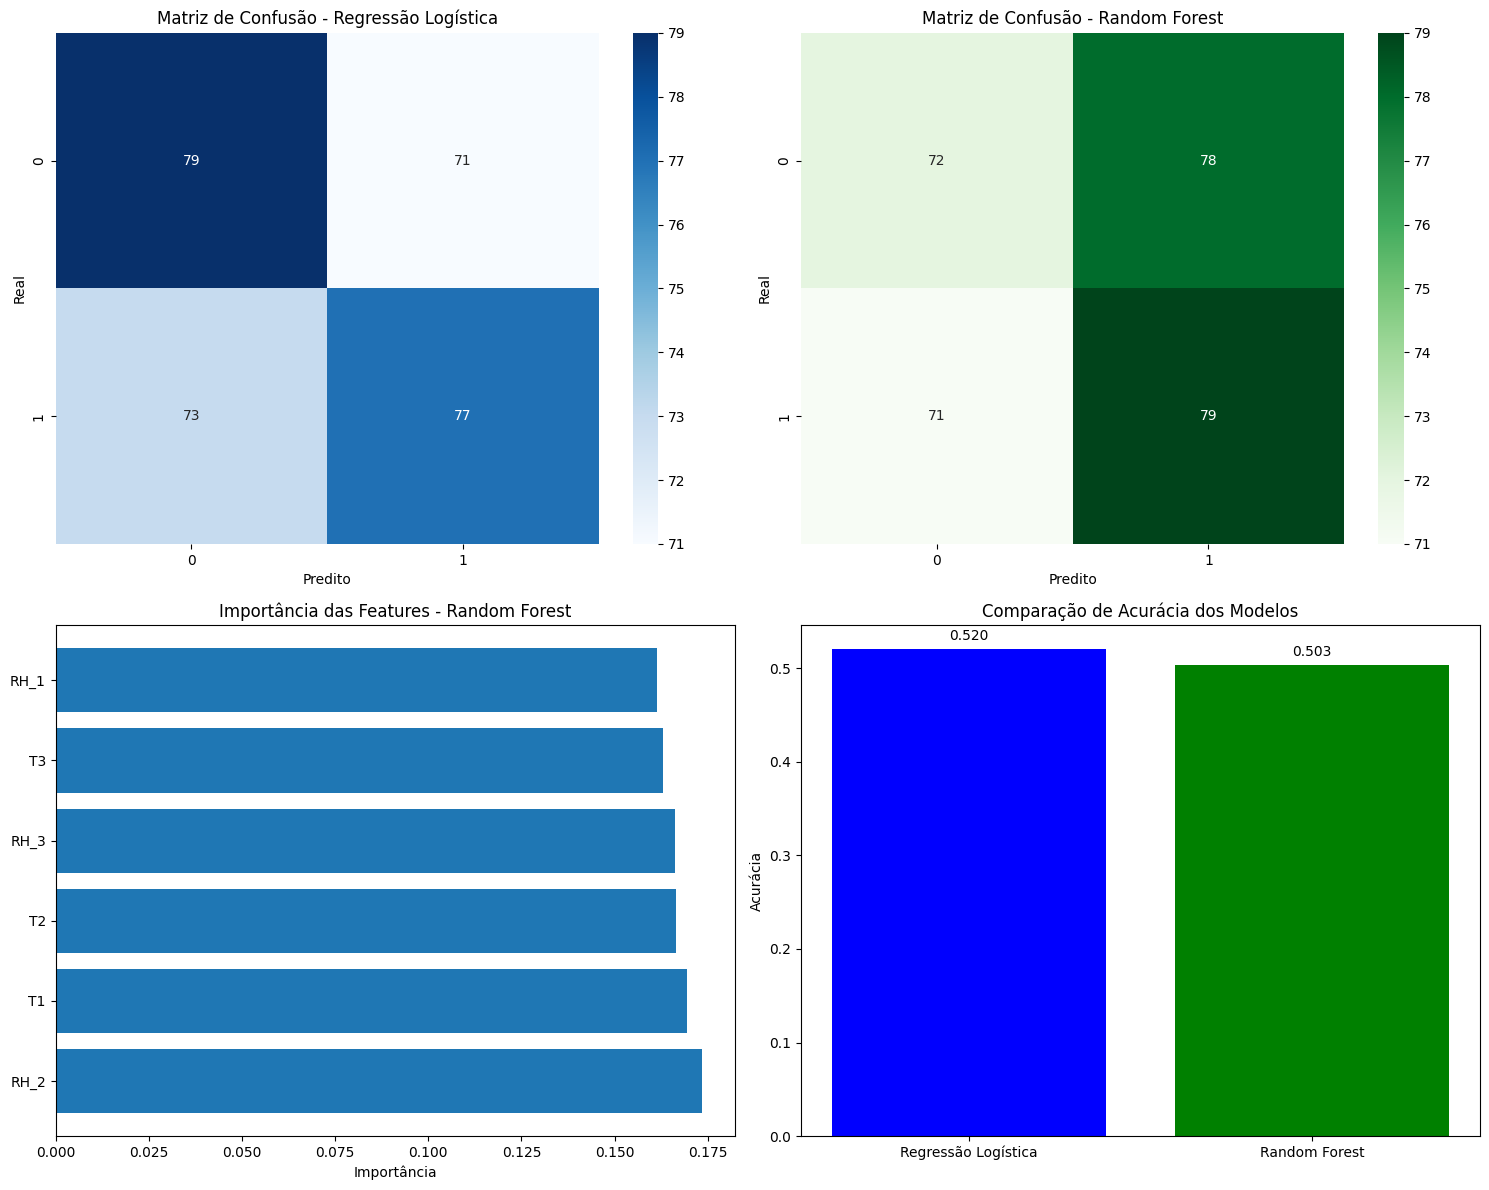


RESULTADOS FINAIS
Regressão Logística - Acurácia: 0.5200
Random Forest - Acurácia: 0.5033

Melhor modelo: Regressão Logística (diferença: 0.0167)


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar os dados

# Exemplo de criação
np.random.seed(42)
n_samples = 1000
df = pd.DataFrame({
    'Appliances': np.random.normal(100, 30, n_samples),
    'T1': np.random.normal(20, 5, n_samples),
    'RH_1': np.random.normal(45, 10, n_samples),
    'T2': np.random.normal(22, 4, n_samples),
    'RH_2': np.random.normal(50, 12, n_samples),
    'T3': np.random.normal(23, 3, n_samples),
    'RH_3': np.random.normal(48, 8, n_samples)
})

# 1. Criar variável
mediana_consumo = df['Appliances'].median()
df['consumo_alto'] = (df['Appliances'] > mediana_consumo).astype(int)

print(f"Mediana do consumo: {mediana_consumo:.2f}")
print(f"Distribuição das classes:")
print(df['consumo_alto'].value_counts())
print(f"Proporção: {df['consumo_alto'].mean():.2%} de consumo alto")


# Selecionar features
features = [col for col in df.columns if col not in ['Appliances', 'consumo_alto']]
X = df[features]
y = df['consumo_alto']

# 3. Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nDimensões dos conjuntos:")
print(f"Treino: {X_train.shape}, Teste: {X_test.shape}")

# 4. Treinar Logistic Regression
print("\n" + "="*50)
print("REGRESSÃO LOGÍSTICA")
print("="*50)

logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)

# Previsões
y_pred_logreg = logreg.predict(X_test)
y_proba_logreg = logreg.predict_proba(X_test)[:, 1]

# Métricas
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Acurácia: {accuracy_logreg:.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_logreg))

# 5. Treinar
print("\n" + "="*50)
print("RANDOM FOREST CLASSIFIER")
print("="*50)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Previsões
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# Métricas
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Acurácia: {accuracy_rf:.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_rf))

# 6. features
print("\nImportância das features (Random Forest):")
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance)

# 7. Visualizações
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Matriz Logistic Regression
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Matriz de Confusão - Regressão Logística')
axes[0, 0].set_xlabel('Predito')
axes[0, 0].set_ylabel('Real')

# Matriz Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[0, 1])
axes[0, 1].set_title('Matriz de Confusão - Random Forest')
axes[0, 1].set_xlabel('Predito')
axes[0, 1].set_ylabel('Real')

#  features
axes[1, 0].barh(feature_importance['feature'], feature_importance['importance'])
axes[1, 0].set_title('Importância das Features - Random Forest')
axes[1, 0].set_xlabel('Importância')

# acurácias
models = ['Regressão Logística', 'Random Forest']
accuracies = [accuracy_logreg, accuracy_rf]
axes[1, 1].bar(models, accuracies, color=['blue', 'green'])
axes[1, 1].set_title('Comparação de Acurácia dos Modelos')
axes[1, 1].set_ylabel('Acurácia')
for i, v in enumerate(accuracies):
    axes[1, 1].text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

# 8 final
print("\n" + "="*50)
print("RESULTADOS FINAIS")
print("="*50)
print(f"Regressão Logística - Acurácia: {accuracy_logreg:.4f}")
print(f"Random Forest - Acurácia: {accuracy_rf:.4f}")

if accuracy_rf > accuracy_logreg:
    melhor_modelo = "Random Forest"
    diferenca = accuracy_rf - accuracy_logreg
else:
    melhor_modelo = "Regressão Logística"
    diferenca = accuracy_logreg - accuracy_rf

print(f"\nMelhor modelo: {melhor_modelo} (diferença: {diferenca:.4f})")

Exercício 35
R: O modelo erra mais para alto consumo quando há mais falsos positivos previu  ou mais para baixo consumo quando há mais falsos negativos.

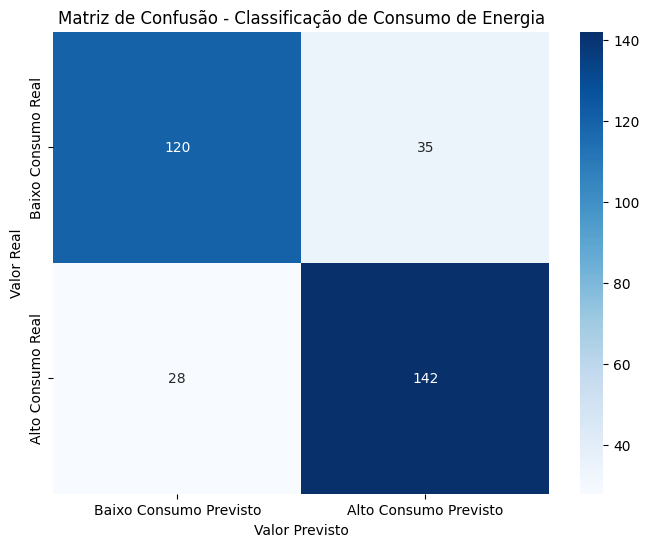

=== MÉTRICAS DE CLASSIFICAÇÃO ===
Acurácia (Accuracy): 80.62%
Precisão (Precision): 80.23%
Recall (Sensibilidade): 83.53%
F1-Score: 81.84%

=== ANÁLISE DOS ERROS ===
Erros de Falso Positivo (previu alto mas era baixo): 35
Erros de Falso Negativo (previu baixo mas era alto): 28

RESPOSTA: O modelo erra MAIS para ALTO consumo (falsos positivos)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


# Matriz
cm = [[120, 35],   # Verdadeiros Negativos (TN), Falsos Positivos
      [28, 142]]   # Falsos Negativos (FN), Verdadeiros Positivos


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Baixo Consumo Previsto', 'Alto Consumo Previsto'],
            yticklabels=['Baixo Consumo Real', 'Alto Consumo Real'])
plt.title('Matriz de Confusão - Classificação de Consumo de Energia')
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.show()

# Cálculo das métricas
tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
total = tn + fp + fn + tp

accuracy = (tp + tn) / total
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print("=== MÉTRICAS DE CLASSIFICAÇÃO ===")
print(f"Acurácia (Accuracy): {accuracy:.2%}")
print(f"Precisão (Precision): {precision:.2%}")
print(f"Recall (Sensibilidade): {recall:.2%}")
print(f"F1-Score: {f1_score:.2%}")
print("\n=== ANÁLISE DOS ERROS ===")
print(f"Erros de Falso Positivo (previu alto mas era baixo): {fp}")
print(f"Erros de Falso Negativo (previu baixo mas era alto): {fn}")

# Respondendo a pergunta específica
if fp > fn:
    print("\nRESPOSTA: O modelo erra MAIS para ALTO consumo (falsos positivos)")
elif fn > fp:
    print("\nRESPOSTA: O modelo erra MAIS para BAIXO consumo (falsos negativos)")
else:
    print("\nRESPOSTA: O modelo erra igualmente para ambos os tipos")
